Шепелев Д.

# **House price prediction**

In [149]:
import warnings
warnings.filterwarnings('ignore')

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# **Подгрузка, анализ и подготовка датасета**

In [210]:
df = pd.read_csv("data/data.csv")

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [212]:
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA


In [213]:
df.shape

(4600, 18)

In [214]:
df["country"].value_counts()

USA    4600
Name: country, dtype: int64

In [215]:
df = df.drop(columns=["country"])

In [216]:
df = df.drop(columns=["date"])

In [217]:
df = df.drop(columns=["street", "city"])

In [218]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
statezip         0
dtype: int64

In [219]:
print(f"invalid price rows count: {df['price'].where(df['price'] == 0).count()}")

invalid price rows count: 49


In [220]:
df = df[df["price"] != 0]

In [221]:
print(f"rows count: {len(df)}")

rows count: 4551


In [222]:
df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,statezip
0,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,WA 98133
1,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,WA 98119
2,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,WA 98042


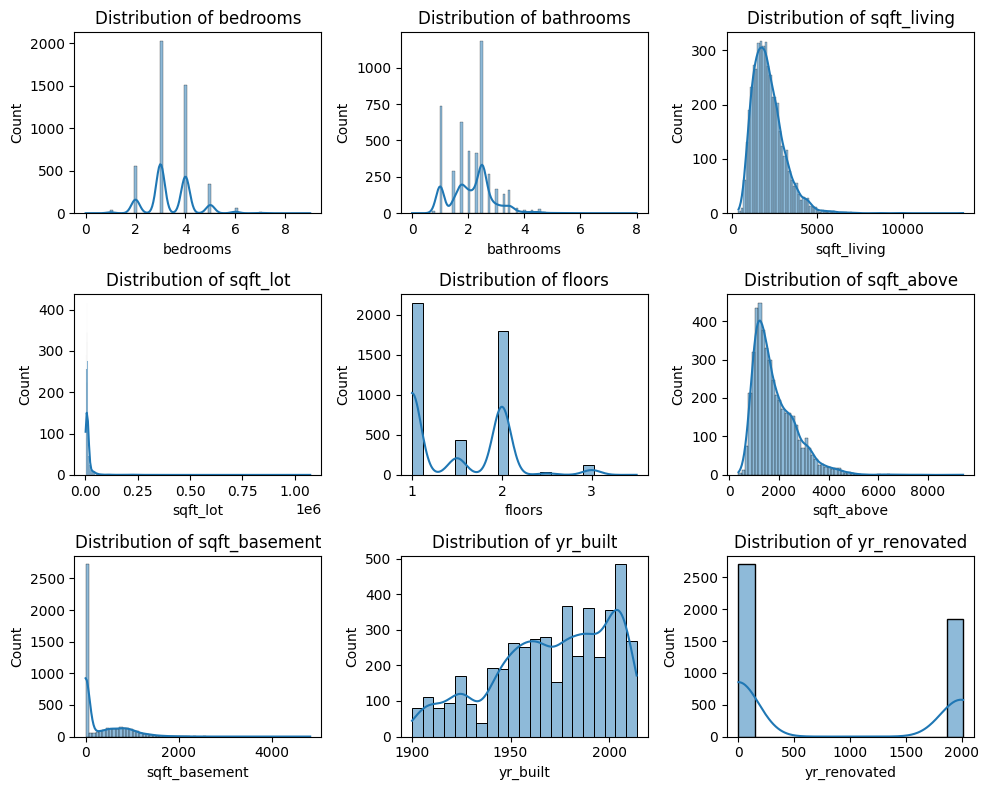

In [223]:
continuous_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

fig = plt.figure(figsize=(10, 8))

for i in range(len(continuous_features)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.histplot(data=df, x=df[continuous_features[i]], kde=True, ax=ax)
    ax.set_title(f'Distribution of {continuous_features[i]}')

plt.tight_layout()

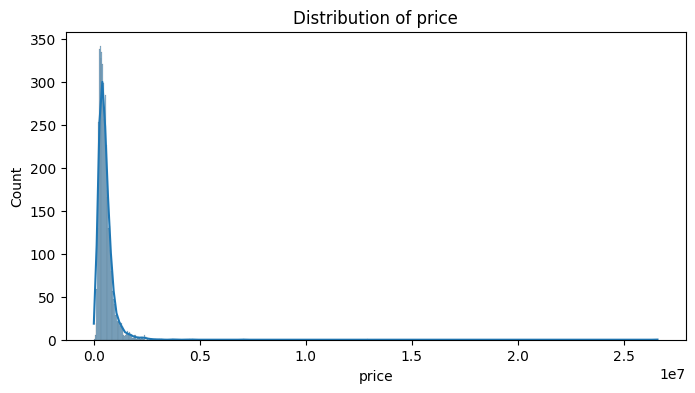

In [224]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x=df["price"], kde=True)
plt.title(f'Distribution of price')
plt.show()

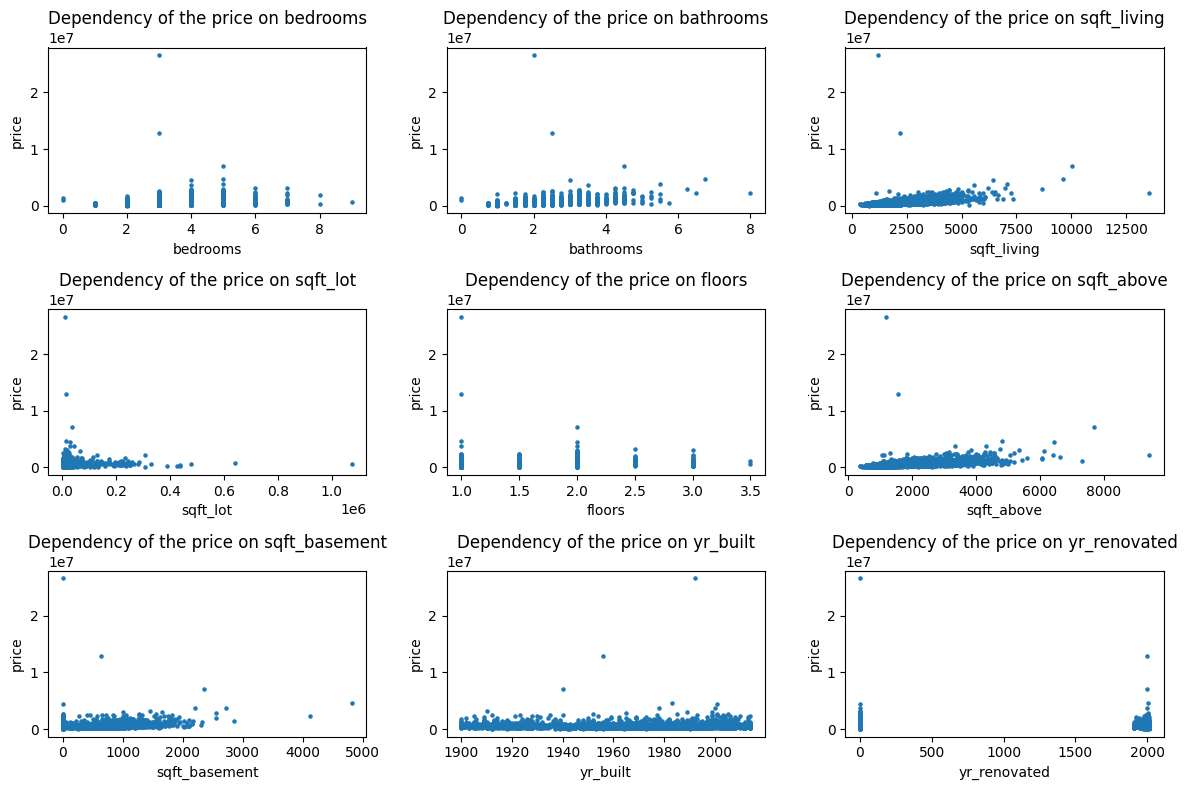

In [225]:
fig = plt.figure(figsize=(12, 8))

for i in range(len(continuous_features)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(df[continuous_features[i]], df['price'], s=5)
    ax.set_xlabel(continuous_features[i])
    ax.set_ylabel('price')
    ax.set_title(f'Dependency of the price on {continuous_features[i]}')

plt.tight_layout()

In [226]:
state = pd.get_dummies(df["statezip"])
view = pd.get_dummies(df["view"])
condition = pd.get_dummies(df["condition"])

In [227]:
df = df.drop(columns=["statezip", "view", "condition"])

In [228]:
df = pd.concat([df, state, view, condition], axis=1)
df.shape

(4551, 98)

# **Разделение на выборки**

In [229]:
y = df["price"].to_numpy()

In [230]:
y.shape

(4551,)

In [231]:
df_x = df.drop(columns=["price"])

x = df_x.to_numpy()
x.shape

(4551, 97)

In [245]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [246]:
print(f"train size: {y_train.shape}")
print(f"test size: {y_test.shape}")

train size: (3640,)
test size: (911,)


# **Обучение и проверка различных методов предобработки**

## **Linear Regression**

In [286]:
lr = LinearRegression()

scores = cross_val_score(lr, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE: {np.sqrt(np.mean(scores) * -1)}')

RMSE: 13686927.79316198


In [287]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ StandardScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ StandardScaler: 4.926501817047433e+16


In [288]:
pipeline = make_pipeline(Normalizer(), LinearRegression())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ Normalizer: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ Normalizer: 170097990.36582726


In [289]:
pipeline = make_pipeline(MinMaxScaler(), LinearRegression())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ MinMaxScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ MinMaxScaler: 6734178617981393.0


## **Ridge Regression**

In [290]:
rr = Ridge()

scores = cross_val_score(rr, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE: {np.sqrt(np.mean(scores) * -1)}')

RMSE: 520753.9625205619


In [291]:
pipeline = make_pipeline(StandardScaler(), Ridge())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ StandardScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ StandardScaler: 521063.5406200825


In [292]:
pipeline = make_pipeline(Normalizer(), Ridge())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ Normalizer: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ Normalizer: 569494.8173005384


In [293]:
pipeline = make_pipeline(MinMaxScaler(), Ridge())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ MinMaxScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ MinMaxScaler: 520688.6387030982


## **Lasso**

In [294]:
lasso = Lasso()

scores = cross_val_score(lasso, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE: {np.sqrt(np.mean(scores) * -1)}')

RMSE: 521061.3415213808


In [295]:
pipeline = make_pipeline(StandardScaler(), Lasso())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ StandardScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ StandardScaler: 521071.91355731344


In [296]:
pipeline = make_pipeline(Normalizer(), Lasso())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ Normalizer: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ Normalizer: 565405.8477718453


In [297]:
pipeline = make_pipeline(MinMaxScaler(), Lasso())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ MinMaxScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ MinMaxScaler: 521061.1025274854


## **ElasticNet**

In [298]:
elnet = ElasticNet()

scores = cross_val_score(elnet, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE: {np.sqrt(np.mean(scores) * -1)}')

RMSE: 541378.2420827001


In [299]:
pipeline = make_pipeline(StandardScaler(), ElasticNet())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ StandardScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ StandardScaler: 522753.8517001258


In [300]:
pipeline = make_pipeline(Normalizer(), ElasticNet())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ Normalizer: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ Normalizer: 599650.4519394506


In [301]:
pipeline = make_pipeline(MinMaxScaler(), ElasticNet())

scores = cross_val_score(pipeline, x_train, y_train, scoring='neg_mean_squared_error')
print(f'RMSE w/ MinMaxScaler: {np.sqrt(np.mean(scores) * -1)}')

RMSE w/ MinMaxScaler: 586926.8276508253


# **GridSearchCV**

## **Ridge Regression**

In [317]:
rr = Ridge()

In [320]:
param_grid = {'alpha': np.logspace(0, 4, 100)}

grid_search_rr = GridSearchCV(estimator=rr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search_rr.fit(x_train, y_train)

print("Best parameters: ", grid_search_rr.best_params_)
print("RMSE for the best papameters: ", np.sqrt(grid_search_rr.best_score_ * -1))

Best parameters:  {'alpha': 2.782559402207125}
RMSE for the best papameters:  520587.62825644563


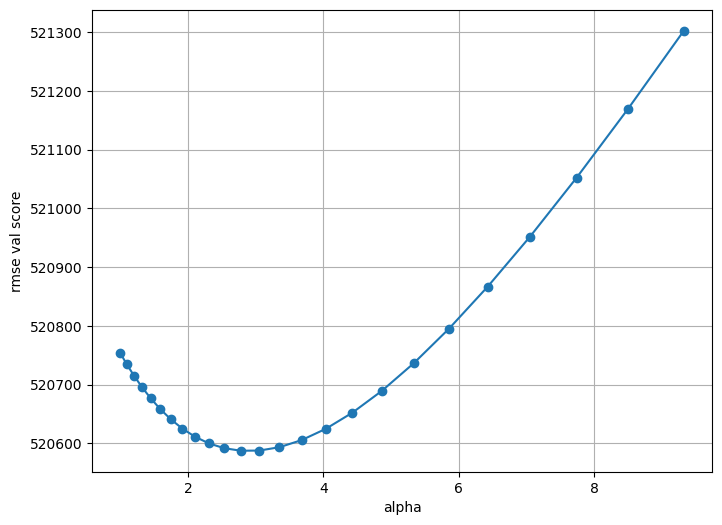

In [326]:
param_values = grid_search_rr.cv_results_['param_alpha'].data
mean_scores = np.sqrt(grid_search_rr.cv_results_['mean_test_score'] * -1)
plt.figure(figsize=(8, 6))
plt.plot(param_values[0:25], mean_scores[0:25], marker='o')
plt.xlabel('alpha')
plt.ylabel('rmse val score')
plt.grid(True)

## **Lasso**

In [327]:
lasso = Lasso()

In [332]:
param_grid = {'alpha': np.logspace(-1, 3, 20)}

grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search_lasso.fit(x_train, y_train)

print("Best parameters: ", grid_search_lasso.best_params_)
print("RMSE for the best papameters: ", np.sqrt(grid_search_lasso.best_score_ * -1))

Best parameters:  {'alpha': 143.8449888287663}
RMSE for the best papameters:  520853.7979606228


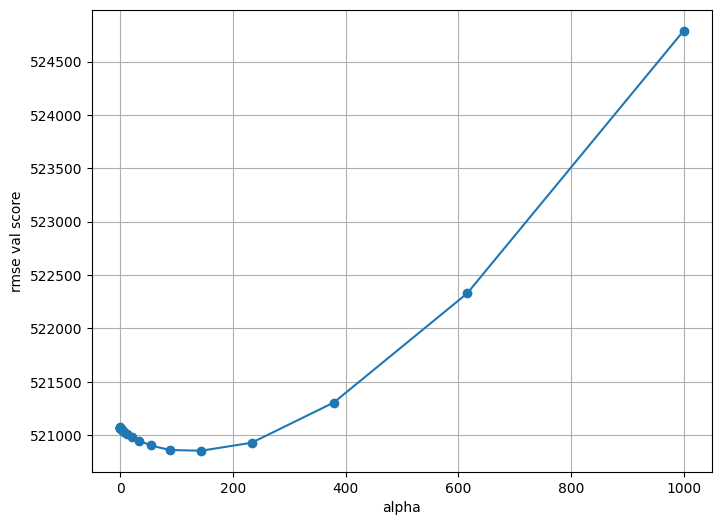

In [336]:
param_values = grid_search_lasso.cv_results_['param_alpha'].data
mean_scores = np.sqrt(grid_search_lasso.cv_results_['mean_test_score'] * -1)
plt.figure(figsize=(8, 6))
plt.plot(param_values, mean_scores, marker='o')
plt.xlabel('alpha')
plt.ylabel('rmse val score')
plt.grid(True)

## **ElasticNet**

In [334]:
elnet = ElasticNet()

In [348]:
param_grid = {'alpha': np.logspace(-10, 2, 20)}

grid_search = GridSearchCV(estimator=elnet, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(x_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("RMSE for the best papameters: ", np.sqrt(grid_search.best_score_ * -1))

Best parameters:  {'alpha': 0.0008858667904100814}
RMSE for the best papameters:  520700.85482810484


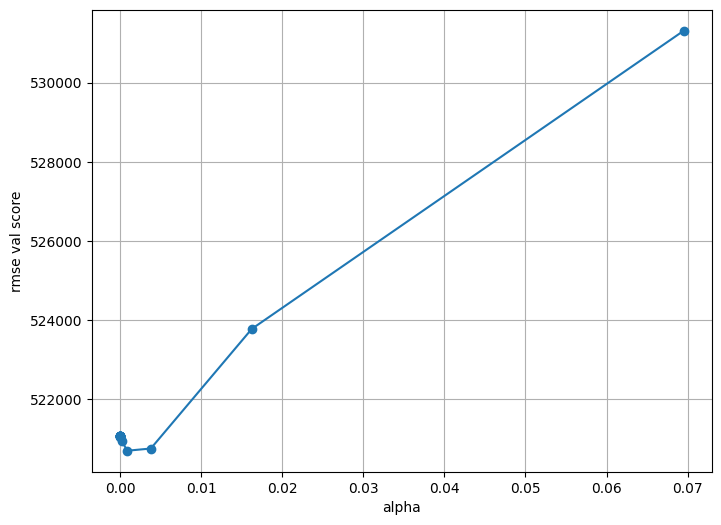

In [353]:
param_values = grid_search.cv_results_['param_alpha'].data
mean_scores = np.sqrt(grid_search.cv_results_['mean_test_score'] * -1)
plt.figure(figsize=(8, 6))
plt.plot(param_values[0:15], mean_scores[0:15], marker='o')
plt.xlabel('alpha')
plt.ylabel('rmse val score')
plt.grid(True)

## **Проверка лучшей модели**

In [358]:
rr = Ridge(alpha=grid_search_rr.best_params_["alpha"])

rr.fit(x_train, y_train)

y_pred = rr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

RMSE: 210057.4239210865


In [359]:
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=grid_search_rr.best_params_["alpha"]))

pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE w/ StandardScaler: {np.sqrt(mse)}')

RMSE w/ StandardScaler: 211886.29632033646


In [365]:
features = df_x.columns.to_numpy()

In [369]:
coefficients = sorted(abs(rr.coef_))[-20:]

print("Наиболее значимые параметры модели:")
for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

Наиболее значимые параметры модели:
bedrooms: 200484.80206809696
bathrooms: 212772.83572155
sqft_living: 213223.28037450157
sqft_lot: 216590.0562091677
floors: 217471.70003038654
waterfront: 225363.86684458394
sqft_above: 230461.88655287153
sqft_basement: 237227.01389170828
yr_built: 238773.68889249925
yr_renovated: 242563.85724846766
WA 98001: 302877.4080991775
WA 98002: 305847.94563391566
WA 98003: 322497.9789583686
WA 98004: 349255.6749697822
WA 98005: 364615.4519772088
WA 98006: 412866.1979459944
WA 98007: 434817.7706574867
WA 98008: 464513.57133849955
WA 98010: 606280.5134718582
WA 98011: 815516.1177900879
